In [1]:
#| echo: false
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests
import time
import us

In [3]:
data = pd.read_csv("/Users/ben/Documents/GitHub/DSML/Data/df_lab4_scraped.csv")
data.head()

,State,Coffee Chain,State Abbreviation,Location Count,Population
0,Alaska,Starbucks,AK,24,733391
1,Alabama,Starbucks,AL,73,5024279
2,Arkansas,Starbucks,AR,33,3011524
3,Arizona,Starbucks,AZ,279,7151502
4,California,Starbucks,CA,2362,39538223


## Location Data Scraping

In [4]:
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/118.0"
}

def get_soup(link, headers = HEADERS, timeout = 120):
    """
        Gets that tasty soup
        Arguments
        ---------
        link: str(website link)
        headers: dict {}
        timeout: int
        
        Returns
        -------
        soup
    """
    response = requests.get(link, headers = headers, timeout = timeout)
    return BeautifulSoup(response.content, "html.parser")

In [242]:
# I was planning on replacing the indexing with a more robust solution, but without being able to test due to Menuism being down,
# I decided to leave it as it is functional
soup = get_soup("https://www.menuism.com/restaurant-locations/starbucks-coffee-39564")
starbucks = soup.find_all("a")[32:83]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/dunkin-donuts-181624")
dunkin = soup.find_all("a")[31:76]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/peets-coffee-tea-84051")
peets = soup.find_all("a")[27:36]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/tim-hortons-190025")
timh = soup.find_all("a")[27:43]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/panera-bread-4258")
panera = soup.find_all("a")[34:80]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/caribou-coffee-164861")
caribou = soup.find_all("a")[27:47]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/au-bon-pain-69342")
abp = soup.find_all("a")[28:50]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/the-coffee-bean-tea-leaf-165988")
tcbtl = soup.find_all("a")[27:35]
time.sleep(1)

soup = get_soup("https://www.menuism.com/restaurant-locations/mcdonalds-21019")
mcd = soup.find_all("a")[40:91]

In [140]:
def count_restaurants(restaurant_soup):
    """
        Creates a dictionary of state and number
        Arguments
        ---------
        restaurant_soup: soup object
        
        Returns
        -------
        {state: num_restaurants}
    """
    num_dict = {}
    for row in restaurant_soup:
        state_num = row.get_text().replace(")", "").split("(")
        if state_num[0].split(" ")[0] in ["North", "South", "West", "Rhode", "New"]:
            state = (state_num[0].split(" ")[0] + " " + state_num[0].split(" ")[1])
        elif state_num[0].split(" ")[0] == "District":
            state = "District of Columbia"
        else:
            state = state_num[0].split(" ")[0]
        num_dict[state] = state_num[1]
    return num_dict

In [243]:
num_starbucks = count_restaurants(starbucks)
num_dunkin = count_restaurants(dunkin)
num_peets = count_restaurants(peets)
num_timh = count_restaurants(timh)
num_panera = count_restaurants(panera)
num_caribou = count_restaurants(caribou)
num_abp = count_restaurants(abp)
num_tcbtl = count_restaurants(tcbtl)
num_mcd = count_restaurants(mcd)

In [244]:
def fill_df(restaurant, count, df = num_rest):
    """
        Fills values for supplied dataframe, for each state
        Arguments
        ---------
        restaurant: str(df column name)
        count: dict {}
        df: pd.DataFrame 
        
        Returns
        -------
        Nothing, function acts in-place
    """
    for i in count.keys():
        df.loc[df["State"] == i, restaurant] = count[i]
        # print(count[i])

In [245]:
def stateabb(state_names):
    abr_names = []
    for state_name in state_names:
        if state_name == "District of Columbia":
            abr_names.append("DC")
        else:
            abr_names.append(us.states.lookup(state_name).abbr)
    return abr_names

In [246]:
num_rest = pd.DataFrame(columns = ["State", "State_Abbreviation", "Starbucks", "Dunkin", "Peets", "Tim_Hortons", "Panera", "Caribou", "Au_Bon_Pain", "Coffee_Bean_Tea_Leaf", "McDonalds"])

num_rest["State"] = num_mcd.keys()

In [247]:
fill_df("Starbucks", num_starbucks)
fill_df("Dunkin", num_dunkin)
fill_df("Peets", num_peets)
fill_df("Tim_Hortons", num_timh)
fill_df("Panera", num_panera)
fill_df("Caribou", num_caribou)
fill_df("Au_Bon_Pain", num_abp)
fill_df("Coffee_Bean_Tea_Leaf", num_tcbtl)
fill_df("McDonalds", num_mcd)

In [248]:
num_rest = num_rest.fillna(value = 0)
num_rest["State_Abbreviation"] = stateabb(num_mcd.keys())
num_rest.head()

,State,State_Abbreviation,Starbucks,Dunkin,Peets,Tim_Hortons,Panera,Caribou,Au_Bon_Pain,Coffee_Bean_Tea_Leaf,McDonalds


## Suplemental Data

In [91]:
soup = get_soup("https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population")
wiki = soup.find_all("table")[0]

states = []
for line in wiki.find_all("a")[8:59]:
    state = str(line).replace("</a", "").split(">")[1]
    if state in ["Puerto Rico", "non-voting"]:
        continue
    else:
        states.append(state)
pops = []
count = 0
for line in wiki.find_all("td")[3::11]:
    count += 1
    if count == 30:
        continue
    else:
        pops.append(line.get_text(strip=True))
    
state_pop = dict(zip(stateabb(states), pops))
state_pop = pd.DataFrame([state_pop]).melt()
state_pop = state_pop.rename(columns = {"variable": "State", "value": "Population"})

In [102]:
# If I were to append this data into my dataframe I would do it like this
# Because of Menuism issues I am instead using the provided data
num_rest = pd.merge(num_rest, state_pop, on = "State")
num_rest

,State_Abbreviation,Starbucks,Dunkin,Peets,Tim_Hortons,Panera,Caribou,Au_Bon_Pain,Coffee_Bean_Tea_Leaf,McDonalds,State,Population


In [111]:
# I have appended this data into the provided data instead of my own dataframe, but the method would be the same just with my dataframe instead
revenues = {
    "Starbucks": 26_580_000_000,
    "Dunkin' Donuts": 1_400_000_000,
    "Peet's Coffee & Tea": 983_000_000,
    "Tim Horton's": 3_820_000_000,
    "Panera Bread": 5_795_000_000,
    "Caribou Coffee": 262_000_000,
    "Au Bon Pain": 41_000_000,
    "The Coffee Bean & Tea Leaf": 500_000_000,
    "McDonald's": 23_180_000_000
}
data["Yearly Revenue"] = data["Coffee Chain"].map(revenues)

In [177]:
regions = {
    "Connecticut": "Northeast",
    "Maine": "Northeast",
    "Massachusetts": "Northeast",
    "New Hampshire": "Northeast",
    "Rhode Island": "Northeast",
    "Vermont": "Northeast",
    "New Jersey": "Northeast",
    "New York": "Northeast",
    "Pennsylvania": "Northeast",
    "Illinois": "Midwest",
    "Indiana": "Midwest",
    "Michigan": "Midwest",
    "Ohio": "Midwest",
    "Wisconsin": "Midwest",
    "Iowa": "Midwest",
    "Kansas": "Midwest",
    "Minnesota": "Midwest",
    "Missouri": "Midwest",
    "Nebraska": "Midwest",
    "North Dakota": "Midwest",
    "South Dakota": "Midwest",
    "Delaware": "South",
    "Florida": "South",
    "Georgia": "South",
    "Maryland": "South",
    "North Carolina": "South",
    "South Carolina": "South",
    "Virginia": "South",
    "District of Columbia": "South",
    "West Virginia": "South",
    "Alabama": "South",
    "Kentucky": "South",
    "Mississippi": "South",
    "Tennessee": "South",
    "Arkansas": "South",
    "Louisiana": "South",
    "Oklahoma": "South",
    "Texas": "South",
    "Arizona": "West",
    "Colorado": "West",
    "Idaho": "West",
    "Montana": "West",
    "Nevada": "West",
    "New Mexico": "West",
    "Utah": "West",
    "Wyoming": "West",
    "Alaska": "West",
    "California": "West",
    "Hawaii": "West",
    "Oregon": "West",
    "Washington": "West"
}

In [178]:
data["Region"] = data["State"].map(regions)

In [223]:
data

,State,Coffee Chain,State Abbreviation,Location Count,Population,Yearly Revenue,Region
0,Alaska,Starbucks,AK,24,733391,26580000000,West
1,Alabama,Starbucks,AL,73,5024279,26580000000,South
2,Arkansas,Starbucks,AR,33,3011524,26580000000,South
3,Arizona,Starbucks,AZ,279,7151502,26580000000,West
4,California,Starbucks,CA,2362,39538223,26580000000,West
...,...,...,...,...,...,...,...
264,Vermont,McDonald's,VT,30,643077,23180000000,Northeast
265,Washington,McDonald's,WA,326,7705281,23180000000,West
266,Wisconsin,McDonald's,WI,353,5893718,23180000000,Midwest
267,West Virginia,McDonald's,WV,107,1793716,23180000000,South


## Analyze

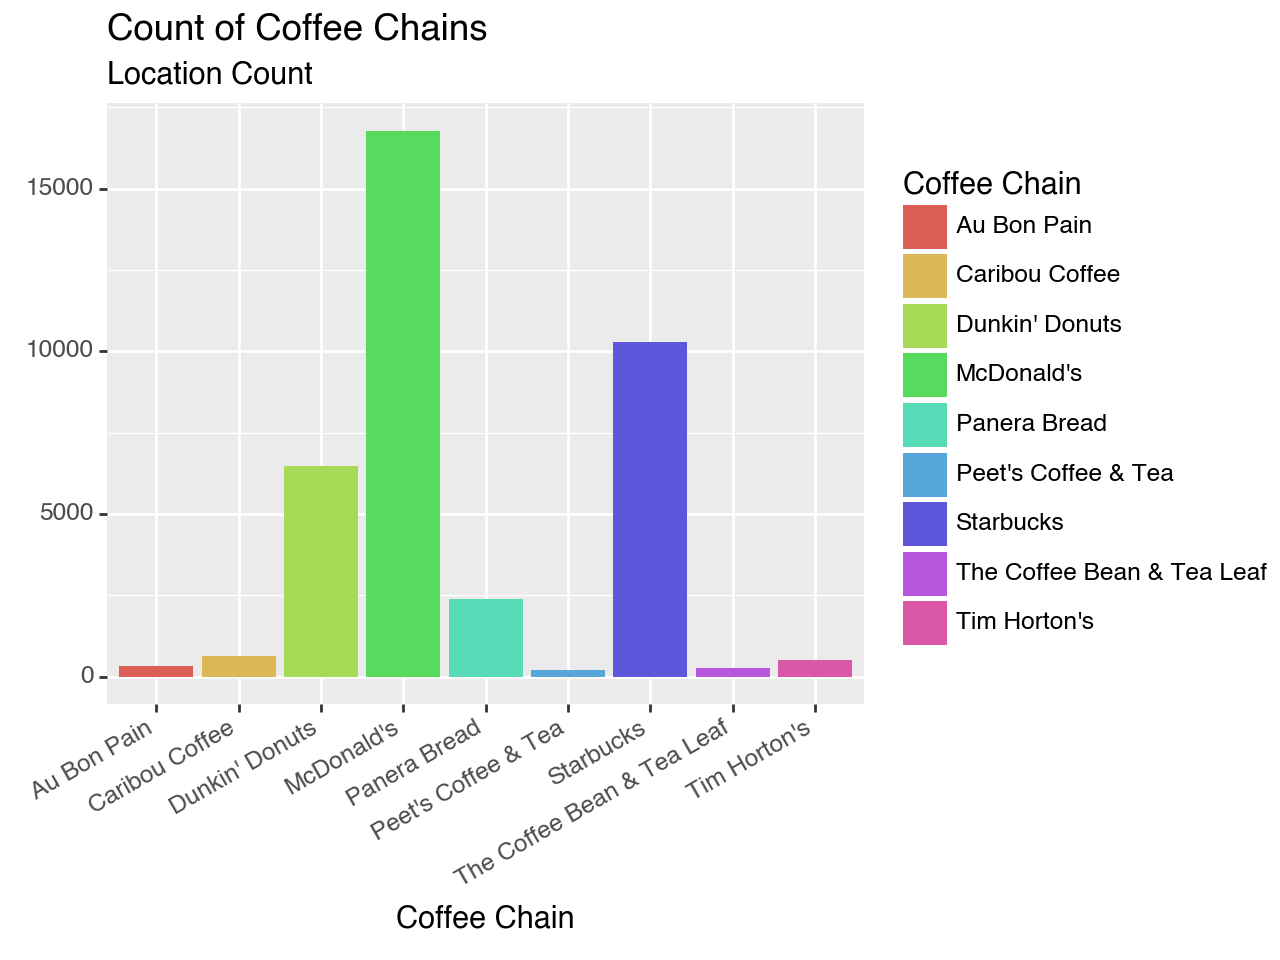

<Figure Size: (640 x 480)>

In [187]:
from plotnine import ggplot, aes, geom_bar, theme, element_text, labs
(ggplot(data, aes(x = "Coffee Chain", y = "Location Count", fill = "Coffee Chain")) +
    geom_bar(stat = "identity") + 
    theme(axis_text_x = element_text(angle = 30, hjust = 1)) +
    labs(
        y = "",
        subtitle = "Location Count",
        title = "Count of Coffee Chains"
    ))

As seen in the figure above, the coffee chains with the most locations are McDonald's, Starbucks, and Dunkin' Donuts. Looking at the figure below shows that New York, Texas, Florida, and California have the most coffee restuarants, which is expected due to their population sizes. 

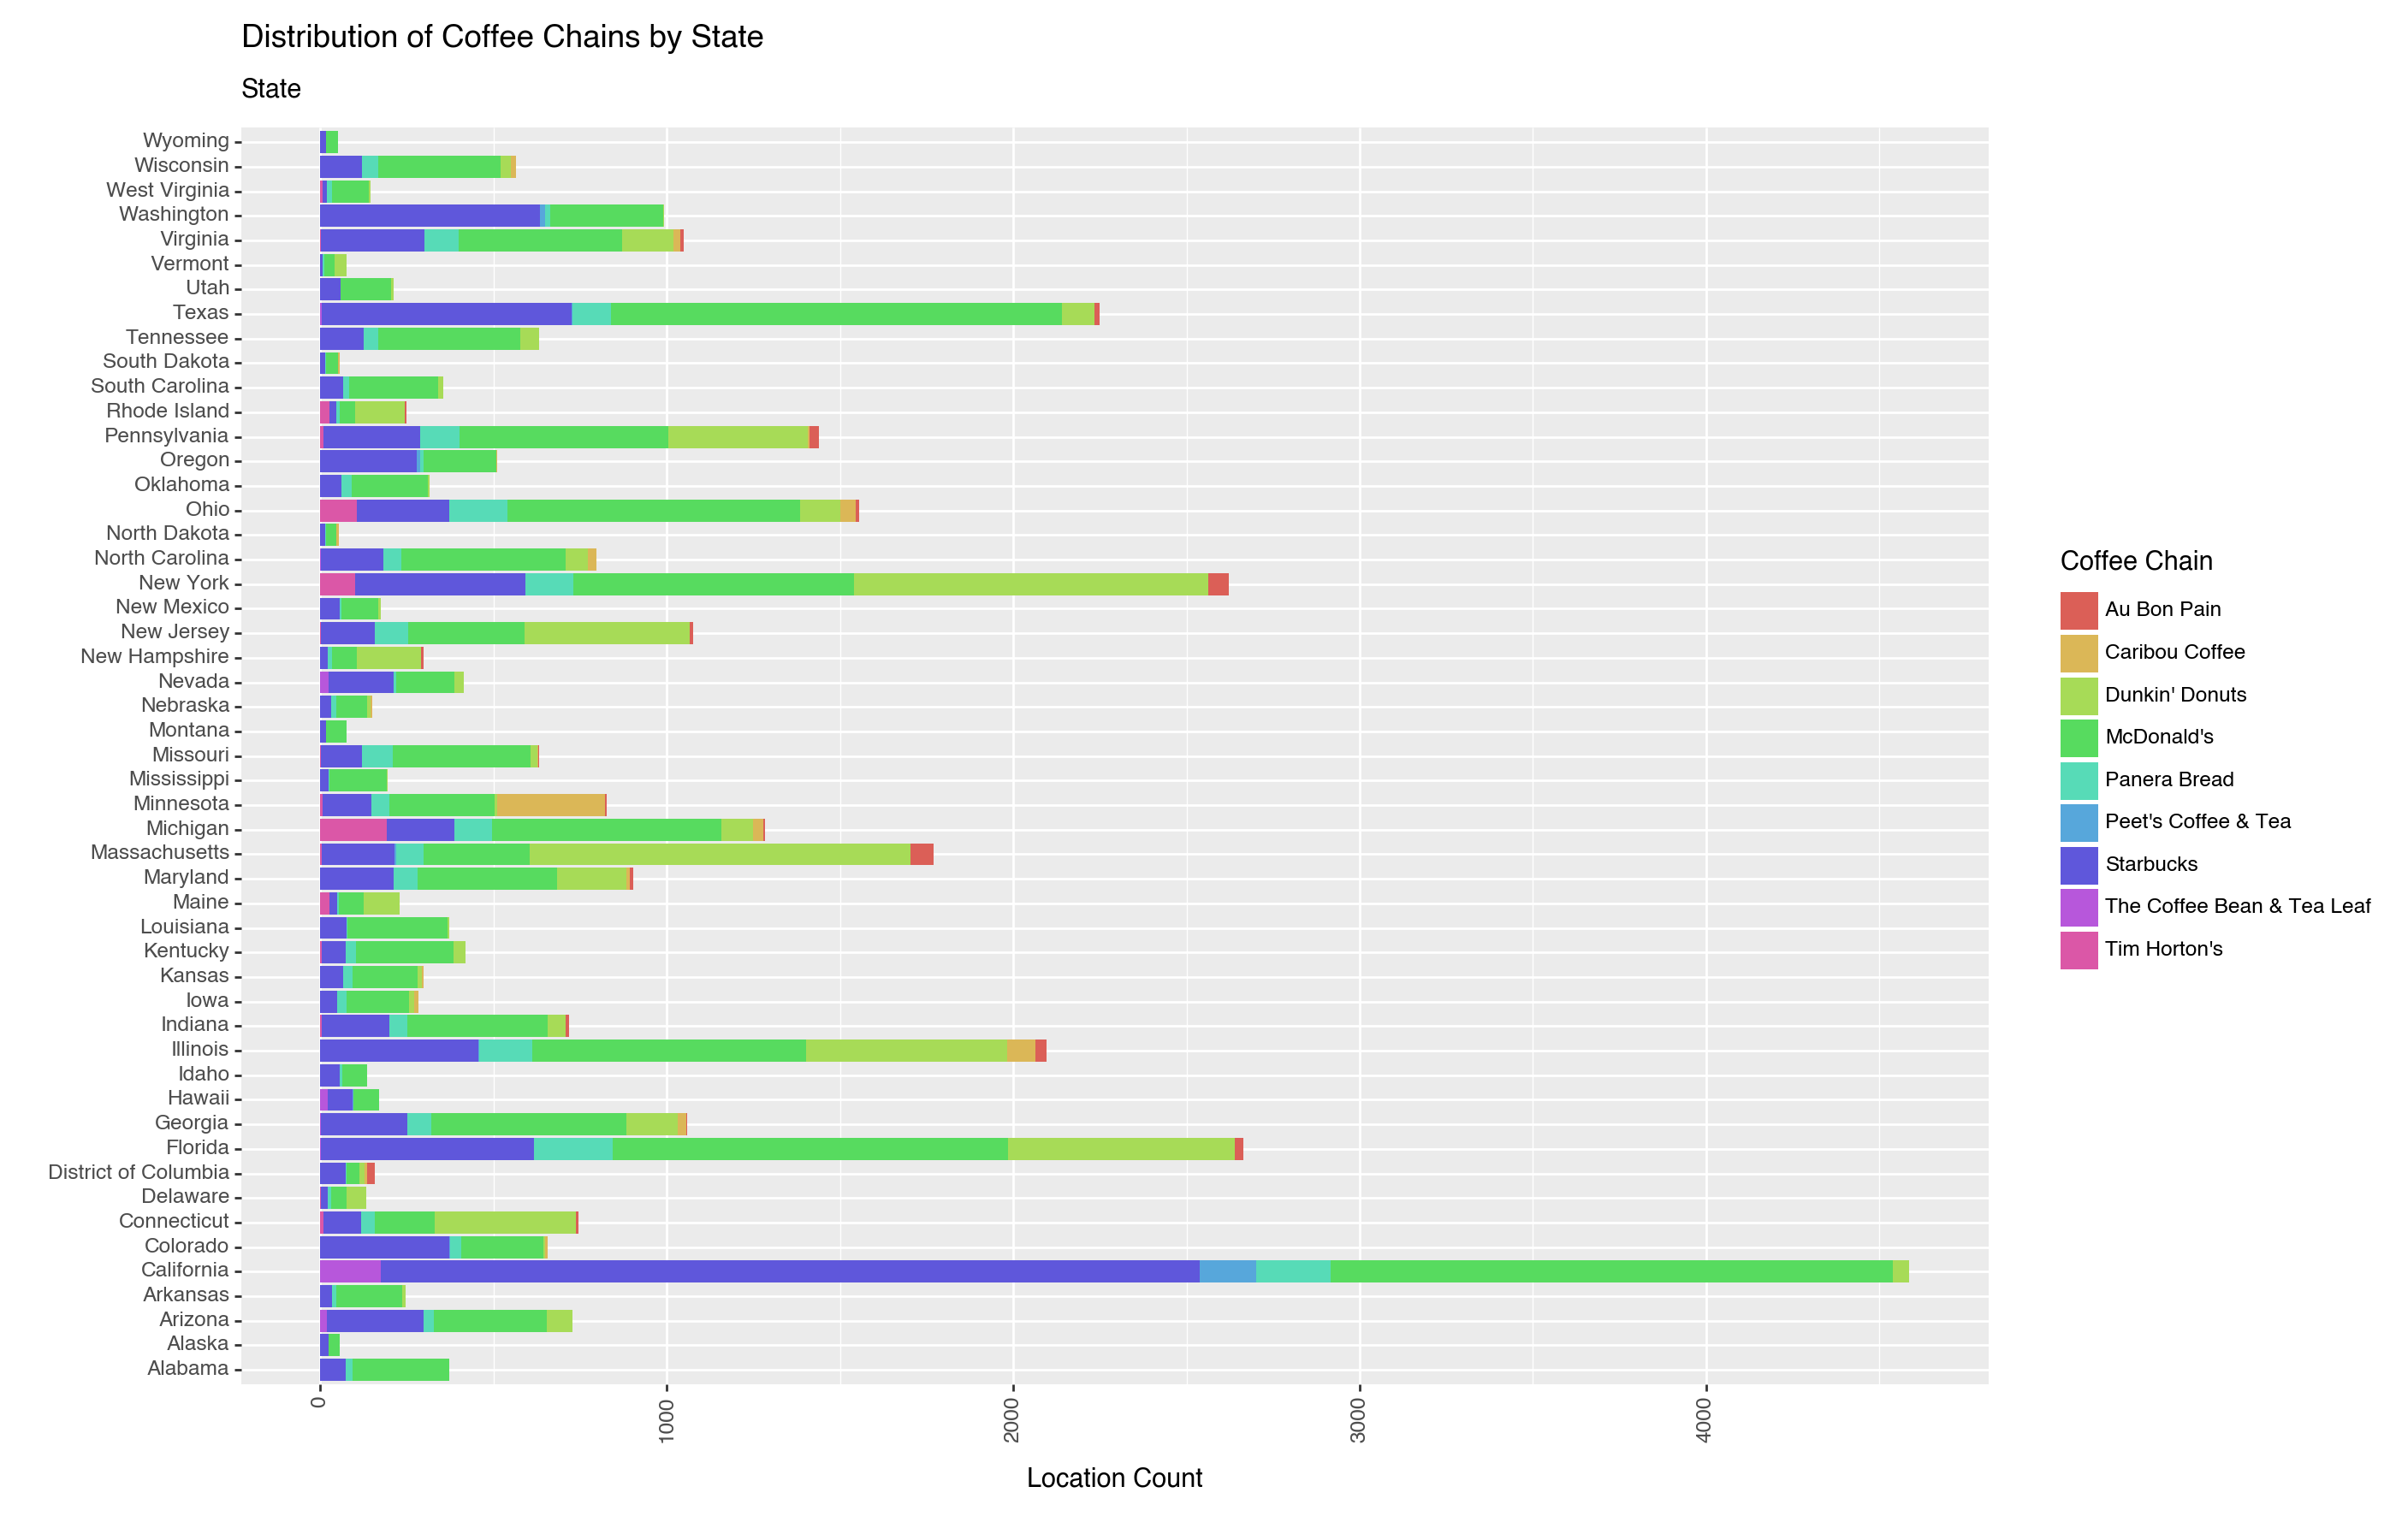

<Figure Size: (1400 x 900)>

In [239]:
from plotnine import geom_point, coord_flip
(ggplot(data, aes(y = "Location Count", x = "State", fill = "Coffee Chain")) +
    geom_bar(stat = "identity") +
    theme(axis_text_x = element_text(angle = 90), figure_size = (14, 9)) +
    coord_flip() +
    labs(
        x = "",
        subtitle = "State",
        title = "Distribution of Coffee Chains by State"
    ))

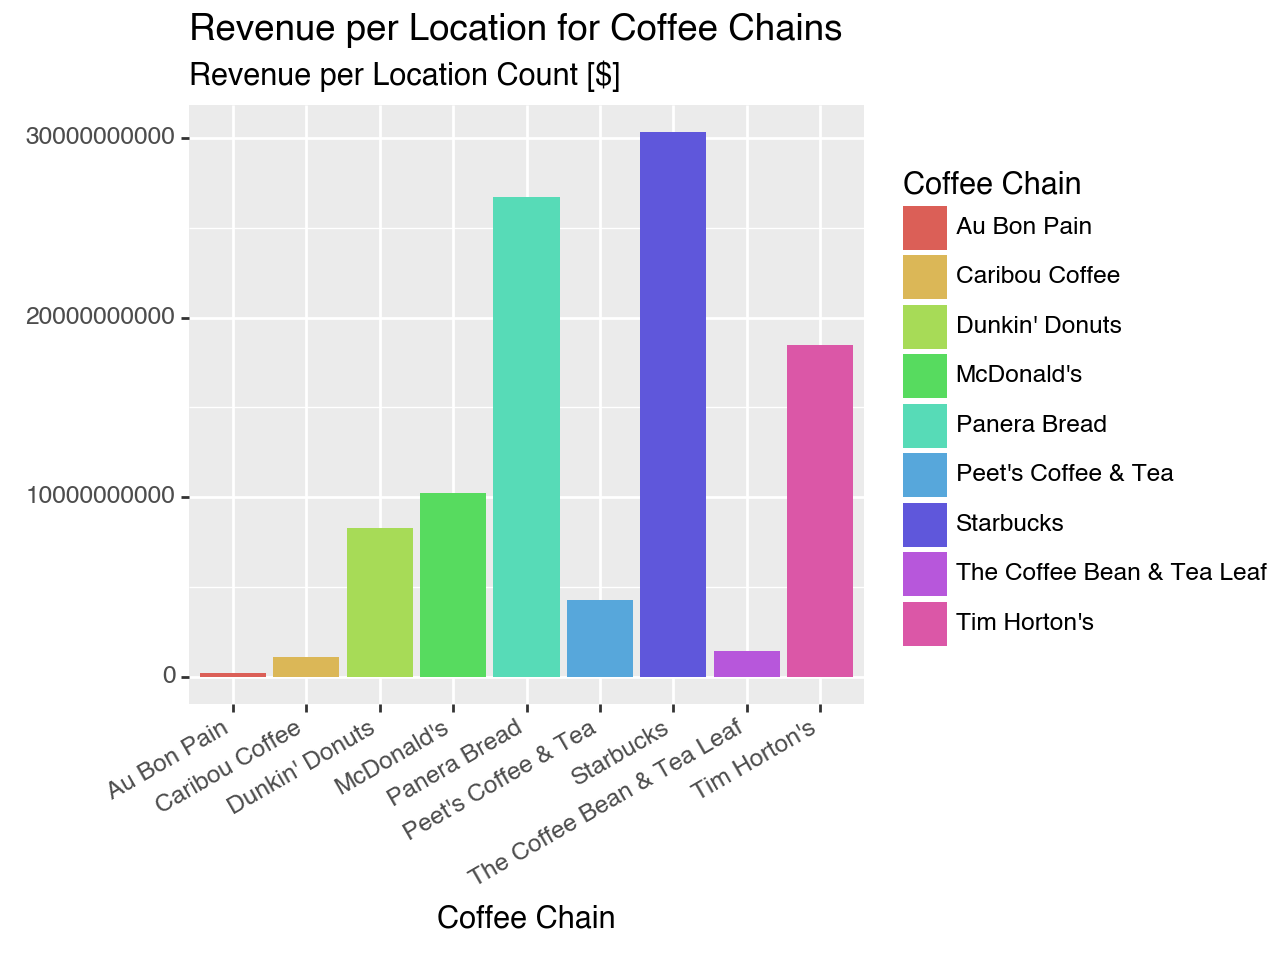

<Figure Size: (640 x 480)>

In [238]:
data["Rev per Loc"] = data["Yearly Revenue"] / data["Location Count"]
(ggplot(data, aes(x = "Coffee Chain", y = "Rev per Loc", fill = "Coffee Chain")) + 
    geom_bar(stat = "identity") + 
    theme(axis_text_x = element_text(angle = 30, hjust = 1)) +
    labs(
        y = "",
        subtitle = "Revenue per Location Count [$]",
        title = "Revenue per Location for Coffee Chains"
    ))

The figure above shows that the coffee chains with the highest revenue per location are Starbucks, Panera, and Tim Horton's. This is surprising as neither Tim Horton's nor Panera have many locations or particularly high revenues, and many of their stores are located outside of the most populous states.

## Automate

In [146]:
def auto_scrape(coffee_shop):
    """
        Scrapes the data for a specific coffee shop
        Arguments
        ---------
        Coffee Shop Name str
        Returns
        -------
        Dataframe
    """
    HEADERS = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/118.0"
    }
    
    links = {
    "Starbucks": "https://www.menuism.com/restaurant-locations/starbucks-coffee-39564",
    "Dunkin'": "https://www.menuism.com/restaurant-locations/dunkin-donuts-181624",
    "Peet's Coffee & Tea": "https://www.menuism.com/restaurant-locations/peets-coffee-tea-84051",
    "Tim Hortons": "https://www.menuism.com/restaurant-locations/tim-hortons-190025",
    "Panera Bread": "https://www.menuism.com/restaurant-locations/panera-bread-4258",
    "Caribou Coffee": "https://www.menuism.com/restaurant-locations/caribou-coffee-164861",
    "Au Bon Pain": "https://www.menuism.com/restaurant-locations/au-bon-pain-69342",
    "The Coffee Bean & Tea Leaf": "https://www.menuism.com/restaurant-locations/the-coffee-bean-tea-leaf-165988",
    "McDonald's": "https://www.menuism.com/restaurant-locations/mcdonalds-21019"
    }
    indexes = {
    "Starbucks": [32, 83],
    "Dunkin'": [31, 76],
    "Peets Coffee & Tea": [27, 36],
    "Tim Hortons": [27, 43],
    "Panera Bread": [34, 80],
    "Caribou Coffee": [27, 47],
    "Au Bon Pain": [28, 50],
    "The Coffee Bean & Tea Leaf": [27, 35],
    "McDonald's": [40, 91]
    }


    soup = get_soup(links[coffee_shop])
    
    shop = soup.find_all("a")[indexes[coffee_shop][0]: indexes[coffee_shop][1]]
    
    num = count_restaurants(shop)
    
    num_rest = pd.DataFrame(columns = ["State", "State_Abbreviation", "Starbucks", "Dunkin", "Peets", "Tim_Hortons", "Panera", "Caribou", "Au_Bon_Pain", "Coffee_Bean_Tea_Leaf", "McDonalds"])
    num_rest["State"] = num.keys()
    
    fill_df(coffee_shop, num)
    
    num_rest = num_rest.fillna(value = 0)
    num_rest["State_Abbreviation"] = stateabb(num_mcd.keys())
    
    return num_rest